# Анализ разнообразия микробиома на основе данных 16S RNA 
## Об этой работе
Ознакомление с миром современных биотехнологий показывает очевидное: данная область переживает что-то похожее на компьютерный бум 80ых. Illumina это новый IBM, ключевые технологии монополизированы, а методы работы имеют скорее любительский характер. К примеру, формат записи генетических последовательностей *fastq* почти не изменился с момента своего появления. 

Целью этой работы является изучение современных методов анализа генетических последовательностей на примере бактериальных сообществ полученных из фекалий мышей. Для манипуляции с данными будет применена связка языка *R* и библиотеки *bioconductor* в силу легкой доступности всех необходимых функций.

## Установка библиотек 

In [6]:
library("knitr")
library("BiocStyle")
.cran_packages <- c("ggplot2", "gridExtra")
.bioc_packages <- c("dada2", "phyloseq", "DECIPHER", "phangorn")
# Load packages into session, and print package version
sapply(c(.cran_packages, .bioc_packages), require, character.only = TRUE)

Loading required package: ggplot2

Loading required package: gridExtra

Loading required package: dada2

Loading required package: Rcpp

Loading required package: phyloseq

Loading required package: DECIPHER

Loading required package: Biostrings

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package

ggplot2 gridExtra     dada2  phyloseq  DECIPHER  phangorn 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE

In [7]:
set.seed(100)

## Данные секвенирования

Данные имеют формат парного считывания с наличием прямого (R1) и обратного (R2) считываний. 

In [2]:
miseq_path <- "./MiSeq_SOP"
list.files(miseq_path)

[1] "F3D0_S188_L001_R1_001.fastq"   "F3D0_S188_L001_R2_001.fastq"  
 [3] "F3D1_S189_L001_R1_001.fastq"   "F3D1_S189_L001_R2_001.fastq"  
 [5] "F3D141_S207_L001_R1_001.fastq" "F3D141_S207_L001_R2_001.fastq"
 [7] "F3D142_S208_L001_R1_001.fastq" "F3D142_S208_L001_R2_001.fastq"
 [9] "F3D143_S209_L001_R1_001.fastq" "F3D143_S209_L001_R2_001.fastq"
[11] "F3D144_S210_L001_R1_001.fastq" "F3D144_S210_L001_R2_001.fastq"
[13] "F3D145_S211_L001_R1_001.fastq" "F3D145_S211_L001_R2_001.fastq"
[15] "F3D146_S212_L001_R1_001.fastq" "F3D146_S212_L001_R2_001.fastq"
[17] "F3D147_S213_L001_R1_001.fastq" "F3D147_S213_L001_R2_001.fastq"
[19] "F3D148_S214_L001_R1_001.fastq" "F3D148_S214_L001_R2_001.fastq"
[21] "F3D149_S215_L001_R1_001.fastq" "F3D149_S215_L001_R2_001.fastq"
[23] "F3D150_S216_L001_R1_001.fastq" "F3D150_S216_L001_R2_001.fastq"
[25] "F3D2_S190_L001_R1_001.fastq"   "F3D2_S190_L001_R2_001.fastq"  
[27] "F3D3_S191_L001_R1_001.fastq"   "F3D3_S191_L001_R2_001.fastq"  
[29] "F3D5_S193_L001_R1_001.fastq"   "F3D5_S193_L001_R2_001.fastq"  
[31] "F3D6_S194_L001_R1_001.fastq"   "F3D6_S194_L001_R2_001.fastq"  
[33] "F3D7_S195_L001_R1_001.fastq"   "F3D7_S195_L001_R2_001.fastq"  
[35] "F3D8_S196_L001_R1_001.fastq"   "F3D8_S196_L001_R2_001.fastq"  
[37] "F3D9_S197_L001_R1_001.fastq"   "F3D9_S197_L001_R2_001.fastq"  
[39] "filtered"                      "HMP_MOCK.v35.fasta"           
[41] "Mock_S280_L001_R1_001.fastq"   "Mock_S280_L001_R2_001.fastq"  
[43] "mouse.dpw.metadata"            "mouse.time.design"            
[45] "stability.batch"               "stability.files"

In [3]:
# Сортировка прямых и обратных считываний 
fnFs <- sort(list.files(miseq_path, pattern="_R1_001.fastq"))
fnRs <- sort(list.files(miseq_path, pattern="_R2_001.fastq"))
# Список названий образцов
sampleNames <- sapply(strsplit(fnFs, "_"), `[`, 1)
# 
fnFs <- file.path(miseq_path, fnFs)
fnRs <- file.path(miseq_path, fnRs)
fnFs[1:3]

[1] "./MiSeq_SOP/F3D0_S188_L001_R1_001.fastq"  
[2] "./MiSeq_SOP/F3D1_S189_L001_R1_001.fastq"  
[3] "./MiSeq_SOP/F3D141_S207_L001_R1_001.fastq"

In [4]:
fnRs[1:3]

[1] "./MiSeq_SOP/F3D0_S188_L001_R2_001.fastq"  
[2] "./MiSeq_SOP/F3D1_S189_L001_R2_001.fastq"  
[3] "./MiSeq_SOP/F3D141_S207_L001_R2_001.fastq"

Перед тем как начать основные манипуляции, оценим качество исходных последовательностей.  

В образцах прямого считывания *fnFs* видим ухудшение их качества ближе к концу последовательности, начиная с позиции 240 и дальше.

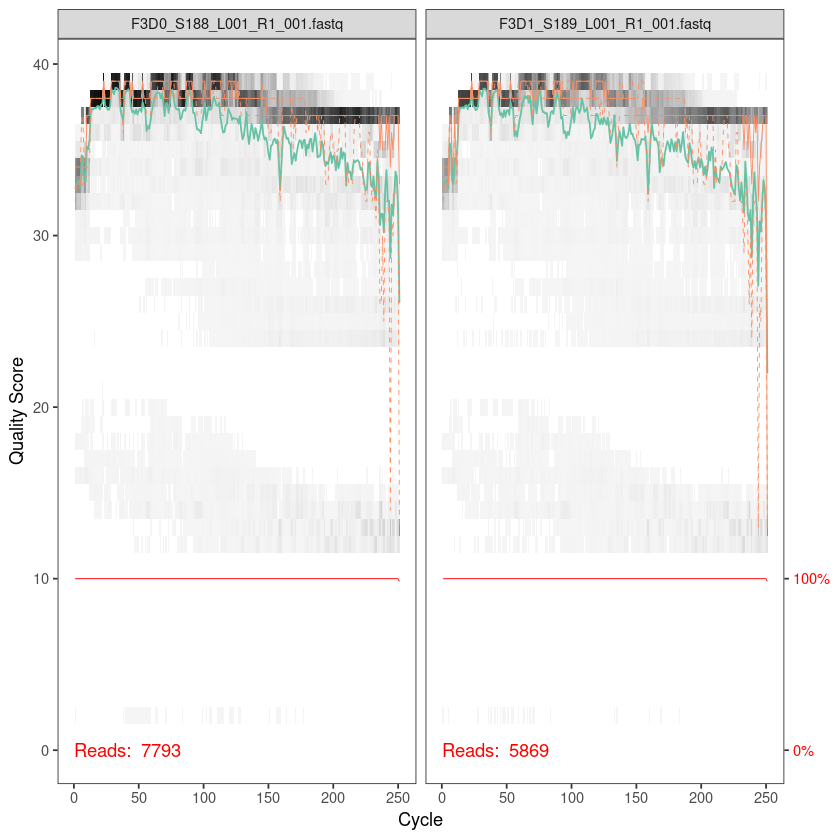

In [8]:
plotQualityProfile(fnFs[1:2])

Аналогично, в образцах обратного считывания *fnRs*, их качество ухудшается начиная с позиции 160 и дальше.

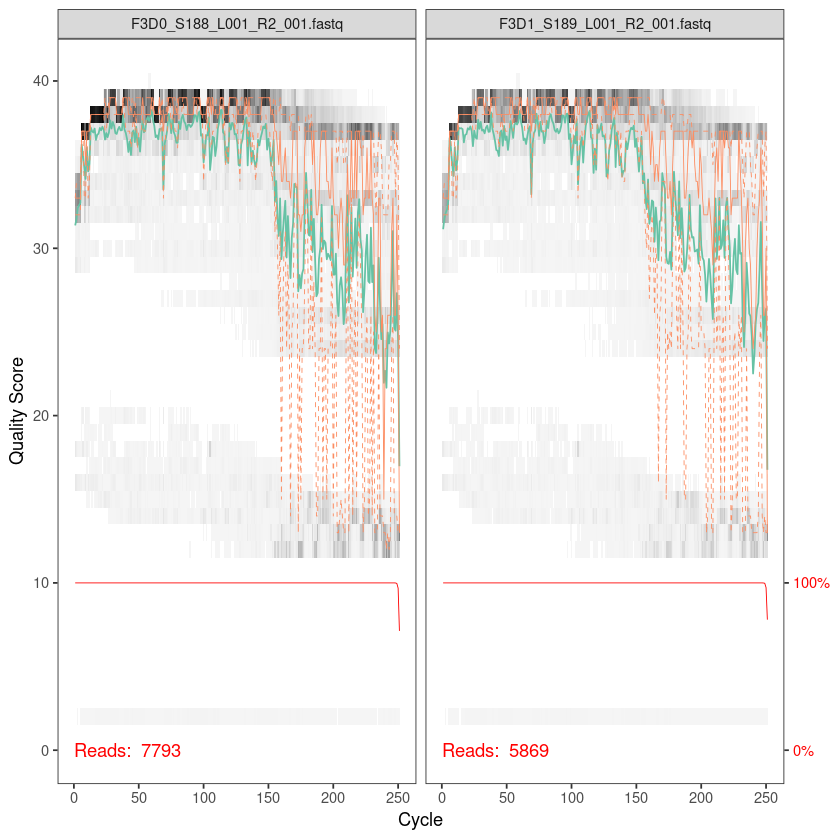

In [7]:
plotQualityProfile(fnRs[1:2])

In [10]:
filt_path <- file.path(miseq_path, "filtered") 
if(!file_test("-d", filt_path)) dir.create(filt_path)
filtFs <- file.path(filt_path, paste0(sampleNames, "_F_filt.fastq.gz"))
filtRs <- file.path(filt_path, paste0(sampleNames, "_R_filt.fastq.gz"))

Обрежем образцы прямой и обратной цепи, начиная с тех позиций, где количество ошибок считывания оказалось велико. Также наложим ряд фильтров одновременно на прямые и обратные считывания наших образцов. (Останутся лишь те образцы, у которых оба считывания пройдут фильтр)

In [11]:
out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs, truncLen=c(240,160),
              maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=FALSE)
head(out)

,reads.in,reads.out
F3D0_S188_L001_R1_001.fastq,7793,7113
F3D1_S189_L001_R1_001.fastq,5869,5299
F3D141_S207_L001_R1_001.fastq,5958,5463
F3D142_S208_L001_R1_001.fastq,3183,2914
F3D143_S209_L001_R1_001.fastq,3178,2941
F3D144_S210_L001_R1_001.fastq,4827,4312
